This notebook uses the library Keras to generalize the problem of the ML_cup 2022.

The notebook uses the following hyperparameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-11-25 00:23:20.341505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 00:23:20.772555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 00:23:20.772612: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-25 00:23:20.853265: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 00:23:21.879276: W tensorflow/stream_executor/platform/de

Loading data for the ML cup 2022

In [2]:
# set a fixed seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [4]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

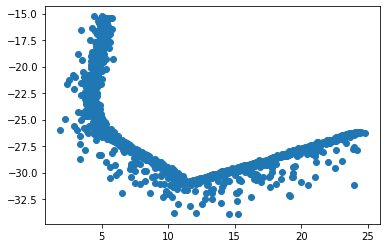

In [5]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

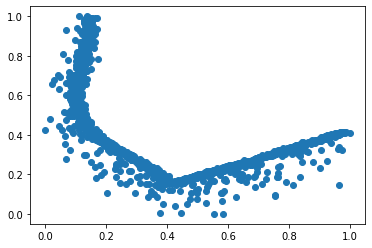

In [7]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) 

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, lasso_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L1(lasso_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L1(lasso_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(lasso_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=5, max_units=15, min_lasso_lambda=0.00001, max_lasso_lambda=0.01, min_lr_rate=0.05, 
                max_lr_rate=0.15, min_mom=0.0, max_mom=0.8, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    lasso_lambda_sampling = "log"
    if(linear_reg):
        lasso_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units > 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'lasso_lambda' represents the lambda coefficient for Lasso regularization (L1)
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    lasso_lambda = hp.Float(
        "lasso_lambda", min_value=min_lasso_lambda, max_value=max_lasso_lambda, sampling=lasso_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, lasso_lambda=lasso_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [11]:
br_l = lambda a : build_regressor(a, my_metric=euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts 
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

2022-11-25 00:23:23.779429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 00:23:23.779643: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 00:23:23.779659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-11-25 00:23:23.780012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [13]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 01m 25s]
val_euclidean_distance: 0.08677176013588905

Best val_euclidean_distance So Far: 0.08552022899190585
Total elapsed time: 00h 51m 55s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 14
lasso_lambda 0.001960746457051476
learning_rate 0.10666014287581548
momentum 0.7434123303083473

best hyperparameters n. 1
units 14
lasso_lambda 0.0036890678737751554
learning_rate 0.06070570762392118
momentum 0.6399186730178088

best hyperparameters n. 2
units 14
lasso_lambda 0.0004451664486020706
learning_rate 0.09833635493780582
momentum 0.7937319163379603



Brief description of the final neural network's structure

In [15]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 14)                140       
                                                                 
 dense_3 (Dense)             (None, 2)                 30        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [16]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.001960746457051476
learning_rate: 0.10666014287581548
momentum: 0.7434123303083473
Score: 0.08552022899190585
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.0036890678737751554
learning_rate: 0.06070570762392118
momentum: 0.6399186730178088
Score: 0.08677176013588905
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.0004451664486020706
learning_rate: 0.09833635493780582
momentum: 0.7937319163379603
Score: 0.08694468314448993
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.001964216536707293
learning_rate: 0.05615447913883606
momentum: 0.5826227601742828
Score: 0.08712079003453255
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 5.8609360352229766e-05
learning_rate: 0.1148755964311353
momentum: 0.7069604495132161
Score: 0.08734819541374843
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [17]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
lasso_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance,
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [18]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 14, 'max_value': 14, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.0015685971656411806, 'conditions': [], 'min_value': 0.0015685971656411806, 'max_value': 0.0023528957484617707, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.08532811430065237, 'conditions': [], 'min_value': 0.08532811430065237, 'max_value': 0.12799217145097858, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5947298642466778, 'conditions': [], 'min_value': 0.5947298642466778, 'max_value': 0.8920947963700168, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [19]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 45s]
val_euclidean_distance: 0.08709569151202838

Best val_euclidean_distance So Far: 0.08442107091347377
Total elapsed time: 00h 39m 11s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [20]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 14
lasso_lambda 0.0017660365619521102
learning_rate 0.08879120726561694
momentum 0.6819346048506542

best hyperparameters n. 1
units 14
lasso_lambda 0.0017194978395274063
learning_rate 0.09419919053106925
momentum 0.8679715938657144

best hyperparameters n. 2
units 14
lasso_lambda 0.0018020275596285521
learning_rate 0.10584803123306209
momentum 0.6516967590598067



Brief description of the final neural network's structure

In [21]:
br_l2 = lambda a : build_regressor(a, my_metric=euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 14)                140       
                                                                 
 dense_3 (Dense)             (None, 2)                 30        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [22]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [23]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
38/38 [==============================] - 1s 5ms/step - loss: 0.0882 - euclidean_distance: 0.3094 - val_loss: 0.0250 - val_euclidean_distance: 0.1637
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0219 - euclidean_distance: 0.1517 - val_loss: 0.0187 - val_euclidean_distance: 0.1403
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0177 - euclidean_distance: 0.1317 - val_loss: 0.0171 - val_euclidean_distance: 0.1364
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0155 - euclidean_distance: 0.1227 - val_loss: 0.0141 - val_euclidean_distance: 0.1128
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1166 - val_loss: 0.0134 - val_euclidean_distance: 0.1119
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1129 - val_loss: 0.0137 - val_euclidean_distance: 0.1159
Epoch 7/1000
38/38 [========

38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0899 - val_loss: 0.0077 - val_euclidean_distance: 0.0907
Epoch 102/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0897 - val_loss: 0.0077 - val_euclidean_distance: 0.0917
Epoch 103/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0888 - val_loss: 0.0074 - val_euclidean_distance: 0.0880
Epoch 104/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0891 - val_loss: 0.0074 - val_euclidean_distance: 0.0884
Epoch 105/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0890 - val_loss: 0.0078 - val_euclidean_distance: 0.0913
Epoch 106/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0888 - val_loss: 0.0074 - val_euclidean_distance: 0.0885
Epoch 107/1000
38/38 [=========

38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0878 - val_loss: 0.0077 - val_euclidean_distance: 0.0888
Epoch 79/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0875 - val_loss: 0.0071 - val_euclidean_distance: 0.0861
Epoch 80/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0880 - val_loss: 0.0073 - val_euclidean_distance: 0.0871
Epoch 81/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0879 - val_loss: 0.0072 - val_euclidean_distance: 0.0864
Epoch 82/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0872 - val_loss: 0.0072 - val_euclidean_distance: 0.0862
Epoch 83/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0871 - val_loss: 0.0073 - val_euclidean_distance: 0.0880
Epoch 84/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0917 - val_loss: 0.0087 - val_euclidean_distance: 0.0973
Epoch 57/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0914 - val_loss: 0.0078 - val_euclidean_distance: 0.0910
Epoch 58/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0908 - val_loss: 0.0085 - val_euclidean_distance: 0.0965
Epoch 59/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0907 - val_loss: 0.0079 - val_euclidean_distance: 0.0910
Epoch 60/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0913 - val_loss: 0.0084 - val_euclidean_distance: 0.0943
Epoch 61/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0916 - val_loss: 0.0078 - val_euclidean_distance: 0.0898
Epoch 62/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.0967 - val_loss: 0.0088 - val_euclidean_distance: 0.0944
Epoch 34/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.0964 - val_loss: 0.0084 - val_euclidean_distance: 0.0916
Epoch 35/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0090 - euclidean_distance: 0.0959 - val_loss: 0.0086 - val_euclidean_distance: 0.0931
Epoch 36/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0090 - euclidean_distance: 0.0958 - val_loss: 0.0089 - val_euclidean_distance: 0.0956
Epoch 37/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0090 - euclidean_distance: 0.0955 - val_loss: 0.0088 - val_euclidean_distance: 0.0947
Epoch 38/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.0949 - val_loss: 0.0086 - val_euclidean_distance: 0.0931
Epoch 39/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0852 - val_loss: 0.0073 - val_euclidean_distance: 0.0875
Epoch 134/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0854 - val_loss: 0.0069 - val_euclidean_distance: 0.0847
Epoch 135/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0847 - val_loss: 0.0069 - val_euclidean_distance: 0.0839
Epoch 136/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0853 - val_loss: 0.0070 - val_euclidean_distance: 0.0846
Epoch 137/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0849 - val_loss: 0.0069 - val_euclidean_distance: 0.0845
Epoch 138/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0855 - val_loss: 0.0073 - val_euclidean_distance: 0.0865
Epoch 139/1000
38/38 [=========

38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0881 - val_loss: 0.0075 - val_euclidean_distance: 0.0897
Epoch 63/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0879 - val_loss: 0.0071 - val_euclidean_distance: 0.0875
Epoch 64/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0883 - val_loss: 0.0070 - val_euclidean_distance: 0.0867
Epoch 65/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0875 - val_loss: 0.0071 - val_euclidean_distance: 0.0879
Epoch 66/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0880 - val_loss: 0.0074 - val_euclidean_distance: 0.0884
Epoch 67/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0882 - val_loss: 0.0070 - val_euclidean_distance: 0.0869
Epoch 68/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0858 - val_loss: 0.0083 - val_euclidean_distance: 0.0921
Epoch 59/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0865 - val_loss: 0.0082 - val_euclidean_distance: 0.0897
Epoch 60/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0867 - val_loss: 0.0084 - val_euclidean_distance: 0.0907
Epoch 61/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0865 - val_loss: 0.0077 - val_euclidean_distance: 0.0861
Epoch 62/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0862 - val_loss: 0.0081 - val_euclidean_distance: 0.0889
Epoch 63/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0861 - val_loss: 0.0078 - val_euclidean_distance: 0.0893
Epoch 64/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0811 - val_loss: 0.0071 - val_euclidean_distance: 0.0828
Epoch 159/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0812 - val_loss: 0.0067 - val_euclidean_distance: 0.0810
Epoch 160/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0810 - val_loss: 0.0067 - val_euclidean_distance: 0.0805
Epoch 161/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0805 - val_loss: 0.0065 - val_euclidean_distance: 0.0792
Epoch 162/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0807 - val_loss: 0.0070 - val_euclidean_distance: 0.0813
Epoch 163/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0809 - val_loss: 0.0065 - val_euclidean_distance: 0.0790
Epoch 164/1000
38/38 [=========

38/38 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0901 - val_loss: 0.0078 - val_euclidean_distance: 0.0896
Epoch 86/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0889 - val_loss: 0.0078 - val_euclidean_distance: 0.0892
Epoch 87/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0892 - val_loss: 0.0076 - val_euclidean_distance: 0.0877
Epoch 88/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0898 - val_loss: 0.0078 - val_euclidean_distance: 0.0891
Epoch 89/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0895 - val_loss: 0.0080 - val_euclidean_distance: 0.0921
Epoch 90/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0897 - val_loss: 0.0075 - val_euclidean_distance: 0.0880
Epoch 91/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0876 - val_loss: 0.0071 - val_euclidean_distance: 0.0868
Epoch 186/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0876 - val_loss: 0.0071 - val_euclidean_distance: 0.0852
Epoch 187/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0868 - val_loss: 0.0071 - val_euclidean_distance: 0.0850
Epoch 188/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0872 - val_loss: 0.0071 - val_euclidean_distance: 0.0871
Epoch 189/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0870 - val_loss: 0.0074 - val_euclidean_distance: 0.0878
Epoch 190/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0873 - val_loss: 0.0070 - val_euclidean_distance: 0.0853
Epoch 191/1000
38/38 [=========

38/38 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0833 - val_loss: 0.0070 - val_euclidean_distance: 0.0836
Epoch 93/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0834 - val_loss: 0.0070 - val_euclidean_distance: 0.0841
Epoch 94/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0834 - val_loss: 0.0069 - val_euclidean_distance: 0.0834
Epoch 95/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0829 - val_loss: 0.0072 - val_euclidean_distance: 0.0849
Epoch 96/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0834 - val_loss: 0.0073 - val_euclidean_distance: 0.0855
Epoch 97/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0836 - val_loss: 0.0069 - val_euclidean_distance: 0.0833
Epoch 98/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0850 - val_loss: 0.0070 - val_euclidean_distance: 0.0846
Epoch 89/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0845 - val_loss: 0.0073 - val_euclidean_distance: 0.0875
Epoch 1/1000
38/38 [==============================] - 1s 5ms/step - loss: 0.0882 - euclidean_distance: 0.2958 - val_loss: 0.0222 - val_euclidean_distance: 0.1574
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0206 - euclidean_distance: 0.1495 - val_loss: 0.0162 - val_euclidean_distance: 0.1295
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0161 - euclidean_distance: 0.1287 - val_loss: 0.0157 - val_euclidean_distance: 0.1328
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.1180 - val_loss: 0.0122 - val_euclidean_distance: 0.1104
Epoch 5/1000
38/38 [====================

38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0855 - val_loss: 0.0074 - val_euclidean_distance: 0.0867
Epoch 100/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0856 - val_loss: 0.0082 - val_euclidean_distance: 0.0918
Epoch 101/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0860 - val_loss: 0.0071 - val_euclidean_distance: 0.0858
Epoch 102/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0855 - val_loss: 0.0073 - val_euclidean_distance: 0.0875
Epoch 103/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0851 - val_loss: 0.0070 - val_euclidean_distance: 0.0846
Epoch 104/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0855 - val_loss: 0.0070 - val_euclidean_distance: 0.0852
Epoch 105/1000
38/38 [=========

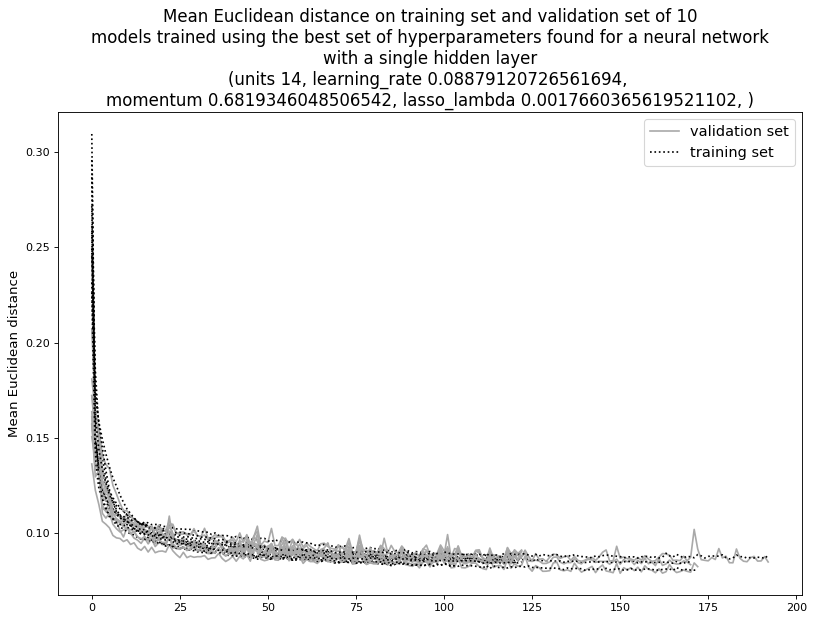

In [24]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']
    list_values_tr[i] = hist[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

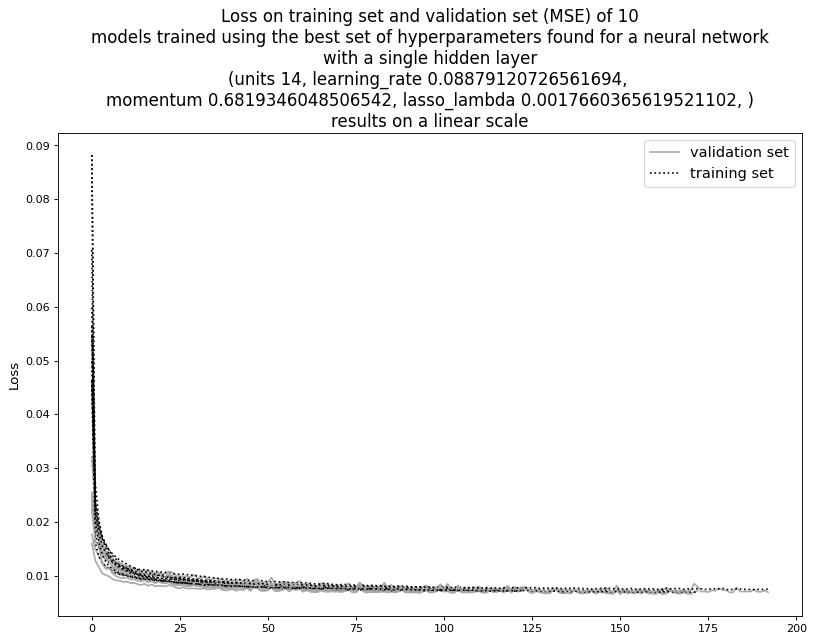

In [25]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

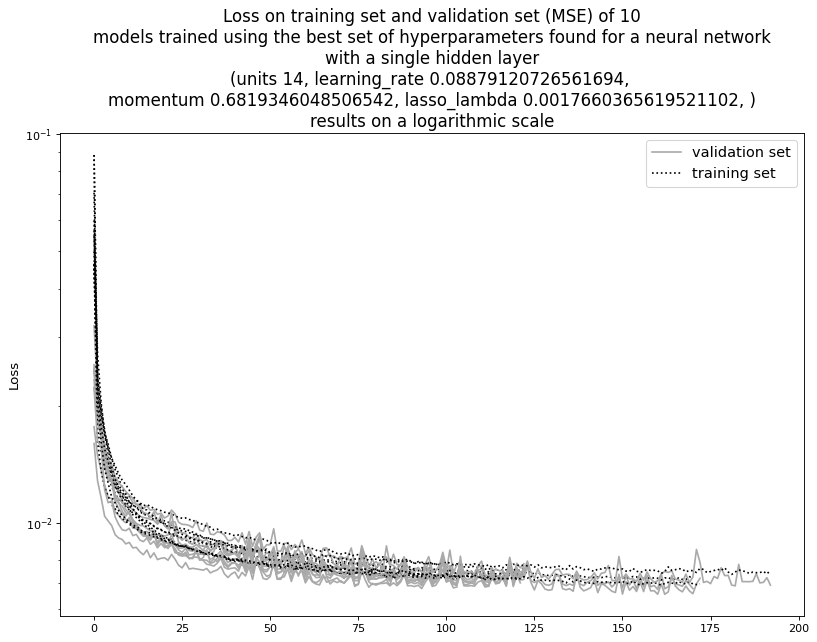

In [26]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [27]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 4
num_units_max = 8
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [28]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 8, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [29]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 01m 00s]
val_euclidean_distance: 0.09617483491698901

Best val_euclidean_distance So Far: 0.08561970790227254
Total elapsed time: 00h 58m 30s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 8
lasso_lambda 0.00045738076137825543
learning_rate 0.057051300093898964
momentum 0.6969247534879426

best hyperparameters n. 1
units 7
lasso_lambda 0.0010690028813507598
learning_rate 0.07841029920196058
momentum 0.7896003171432663

best hyperparameters n. 2
units 8
lasso_lambda 0.00024988845369135974
learning_rate 0.06924993817943724
momentum 0.5849739693777195



Brief description of the final neural network's structure

In [31]:
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [32]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
lasso_lambda: 0.00045738076137825543
learning_rate: 0.057051300093898964
momentum: 0.6969247534879426
Score: 0.08561970790227254
Trial summary
Hyperparameters:
units: 7
lasso_lambda: 0.0010690028813507598
learning_rate: 0.07841029920196058
momentum: 0.7896003171432663
Score: 0.08577384054660797
Trial summary
Hyperparameters:
units: 8
lasso_lambda: 0.00024988845369135974
learning_rate: 0.06924993817943724
momentum: 0.5849739693777195
Score: 0.08708528677622478
Trial summary
Hyperparameters:
units: 6
lasso_lambda: 0.0006873089619913789
learning_rate: 0.0552659448674125
momentum: 0.2738647550585968
Score: 0.08750908076763153
Trial summary
Hyperparameters:
units: 8
lasso_lambda: 0.005681029827217129
learning_rate: 0.1344171931931599
momentum: 0.6250034523798649
Score: 0.08763523027300835
Trial summary
Hyperparameters:
units: 5
lasso_lambda: 0.00

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [33]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
lasso_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, 
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [34]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.00036590460910260436, 'conditions': [], 'min_value': 0.00036590460910260436, 'max_value': 0.0005488569136539066, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.04564104007511917, 'conditions': [], 'min_value': 0.04564104007511917, 'max_value': 0.06846156011267876, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5575398027903541, 'conditions': [], 'min_value': 0.5575398027903541, 'max_value': 0.8363097041855312, 'step': None, 'sampling': 'linear'}


In [35]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 01m 28s]
val_euclidean_distance: 0.0896546021103859

Best val_euclidean_distance So Far: 0.08211581408977509
Total elapsed time: 01h 03m 31s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [36]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 8
lasso_lambda 0.0003690117011524649
learning_rate 0.06641801619436552
momentum 0.7654328306717406

best hyperparameters n. 1
units 8
lasso_lambda 0.0005443680207100645
learning_rate 0.06482790656170187
momentum 0.8115472714275089

best hyperparameters n. 2
units 8
lasso_lambda 0.00048260801311113494
learning_rate 0.06328118254070977
momentum 0.609546261943958



Brief description of the final neural network's structure

In [37]:
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [38]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [39]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
38/38 [==============================] - 1s 6ms/step - loss: 0.0396 - euclidean_distance: 0.2363 - val_loss: 0.0183 - val_euclidean_distance: 0.1673
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0165 - euclidean_distance: 0.1533 - val_loss: 0.0146 - val_euclidean_distance: 0.1424
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.1381 - val_loss: 0.0123 - val_euclidean_distance: 0.1259
Epoch 4/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0122 - euclidean_distance: 0.1262 - val_loss: 0.0114 - val_euclidean_distance: 0.1210
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0115 - euclidean_distance: 0.1211 - val_loss: 0.0109 - val_euclidean_distance: 0.1170
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.1169 - val_loss: 0.0105 - val_euclidean_distance: 0.1144
Epoch 7/1000
38/38 [========

38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0943 - val_loss: 0.0077 - val_euclidean_distance: 0.0954
Epoch 27/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0937 - val_loss: 0.0075 - val_euclidean_distance: 0.0931
Epoch 28/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0942 - val_loss: 0.0073 - val_euclidean_distance: 0.0922
Epoch 29/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0931 - val_loss: 0.0072 - val_euclidean_distance: 0.0915
Epoch 30/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0933 - val_loss: 0.0072 - val_euclidean_distance: 0.0921
Epoch 31/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0919 - val_loss: 0.0073 - val_euclidean_distance: 0.0926
Epoch 32/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.1006 - val_loss: 0.0086 - val_euclidean_distance: 0.1038
Epoch 26/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0989 - val_loss: 0.0082 - val_euclidean_distance: 0.1002
Epoch 27/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0978 - val_loss: 0.0082 - val_euclidean_distance: 0.0992
Epoch 28/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0986 - val_loss: 0.0081 - val_euclidean_distance: 0.0990
Epoch 29/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0971 - val_loss: 0.0082 - val_euclidean_distance: 0.0990
Epoch 30/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0965 - val_loss: 0.0084 - val_euclidean_distance: 0.1012
Epoch 31/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - euclidean_distance: 0.0815 - val_loss: 0.0065 - val_euclidean_distance: 0.0864
Epoch 126/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - euclidean_distance: 0.0833 - val_loss: 0.0067 - val_euclidean_distance: 0.0879
Epoch 127/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - euclidean_distance: 0.0829 - val_loss: 0.0061 - val_euclidean_distance: 0.0831
Epoch 128/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0820 - val_loss: 0.0061 - val_euclidean_distance: 0.0833
Epoch 129/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - euclidean_distance: 0.0820 - val_loss: 0.0066 - val_euclidean_distance: 0.0869
Epoch 130/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - euclidean_distance: 0.0819 - val_loss: 0.0064 - val_euclidean_distance: 0.0860
Epoch 131/1000
38/38 [=========

38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0857 - val_loss: 0.0065 - val_euclidean_distance: 0.0870
Epoch 79/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0861 - val_loss: 0.0075 - val_euclidean_distance: 0.0932
Epoch 80/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0870 - val_loss: 0.0068 - val_euclidean_distance: 0.0882
Epoch 81/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0853 - val_loss: 0.0069 - val_euclidean_distance: 0.0892
Epoch 82/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0855 - val_loss: 0.0065 - val_euclidean_distance: 0.0860
Epoch 83/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0064 - euclidean_distance: 0.0848 - val_loss: 0.0066 - val_euclidean_distance: 0.0869
Epoch 84/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0913 - val_loss: 0.0069 - val_euclidean_distance: 0.0891
Epoch 60/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0919 - val_loss: 0.0070 - val_euclidean_distance: 0.0890
Epoch 61/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0918 - val_loss: 0.0071 - val_euclidean_distance: 0.0902
Epoch 62/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0914 - val_loss: 0.0077 - val_euclidean_distance: 0.0957
Epoch 63/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0902 - val_loss: 0.0069 - val_euclidean_distance: 0.0896
Epoch 64/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0902 - val_loss: 0.0074 - val_euclidean_distance: 0.0937
Epoch 65/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0858 - val_loss: 0.0069 - val_euclidean_distance: 0.0897
Epoch 81/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0064 - euclidean_distance: 0.0855 - val_loss: 0.0070 - val_euclidean_distance: 0.0903
Epoch 82/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0064 - euclidean_distance: 0.0849 - val_loss: 0.0065 - val_euclidean_distance: 0.0857
Epoch 83/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0063 - euclidean_distance: 0.0843 - val_loss: 0.0065 - val_euclidean_distance: 0.0856
Epoch 84/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0063 - euclidean_distance: 0.0842 - val_loss: 0.0065 - val_euclidean_distance: 0.0858
Epoch 85/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0064 - euclidean_distance: 0.0853 - val_loss: 0.0071 - val_euclidean_distance: 0.0917
Epoch 86/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0809 - val_loss: 0.0065 - val_euclidean_distance: 0.0843
Epoch 81/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0804 - val_loss: 0.0065 - val_euclidean_distance: 0.0842
Epoch 82/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0804 - val_loss: 0.0063 - val_euclidean_distance: 0.0821
Epoch 83/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - euclidean_distance: 0.0801 - val_loss: 0.0062 - val_euclidean_distance: 0.0816
Epoch 84/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - euclidean_distance: 0.0798 - val_loss: 0.0062 - val_euclidean_distance: 0.0825
Epoch 85/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0808 - val_loss: 0.0064 - val_euclidean_distance: 0.0833
Epoch 86/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0872 - val_loss: 0.0067 - val_euclidean_distance: 0.0893
Epoch 49/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0876 - val_loss: 0.0066 - val_euclidean_distance: 0.0884
Epoch 50/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0876 - val_loss: 0.0066 - val_euclidean_distance: 0.0890
Epoch 51/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0865 - val_loss: 0.0071 - val_euclidean_distance: 0.0918
Epoch 52/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0870 - val_loss: 0.0065 - val_euclidean_distance: 0.0883
Epoch 53/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0877 - val_loss: 0.0069 - val_euclidean_distance: 0.0904
Epoch 54/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.1045 - val_loss: 0.0095 - val_euclidean_distance: 0.1051
Epoch 16/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0095 - euclidean_distance: 0.1032 - val_loss: 0.0091 - val_euclidean_distance: 0.1032
Epoch 17/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.1015 - val_loss: 0.0090 - val_euclidean_distance: 0.1035
Epoch 18/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.1025 - val_loss: 0.0084 - val_euclidean_distance: 0.0986
Epoch 19/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0090 - euclidean_distance: 0.1007 - val_loss: 0.0083 - val_euclidean_distance: 0.0987
Epoch 20/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0086 - euclidean_distance: 0.0993 - val_loss: 0.0084 - val_euclidean_distance: 0.0978
Epoch 21/1000
38/38 [===============

38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0820 - val_loss: 0.0061 - val_euclidean_distance: 0.0820
Epoch 116/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0809 - val_loss: 0.0062 - val_euclidean_distance: 0.0821
Epoch 117/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0061 - euclidean_distance: 0.0808 - val_loss: 0.0062 - val_euclidean_distance: 0.0823
Epoch 118/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0060 - euclidean_distance: 0.0808 - val_loss: 0.0064 - val_euclidean_distance: 0.0839
Epoch 119/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - euclidean_distance: 0.0817 - val_loss: 0.0062 - val_euclidean_distance: 0.0830
Epoch 1/1000
38/38 [==============================] - 1s 6ms/step - loss: 0.0652 - euclidean_distance: 0.2888 - val_loss: 0.0249 - val_euclidean_distance: 0.1976
Epoch 2/1000
38/38 [=============

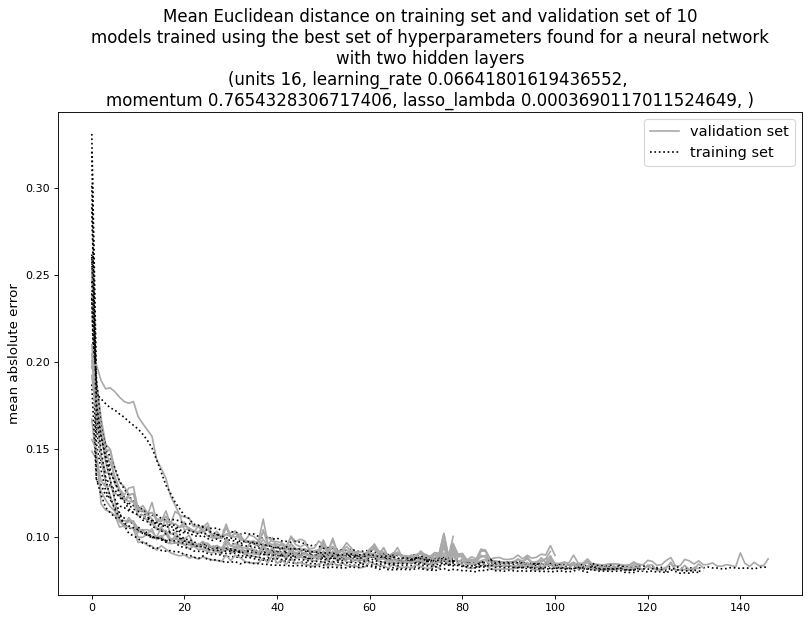

In [40]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']
    list_values_tr[i] = hist2[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

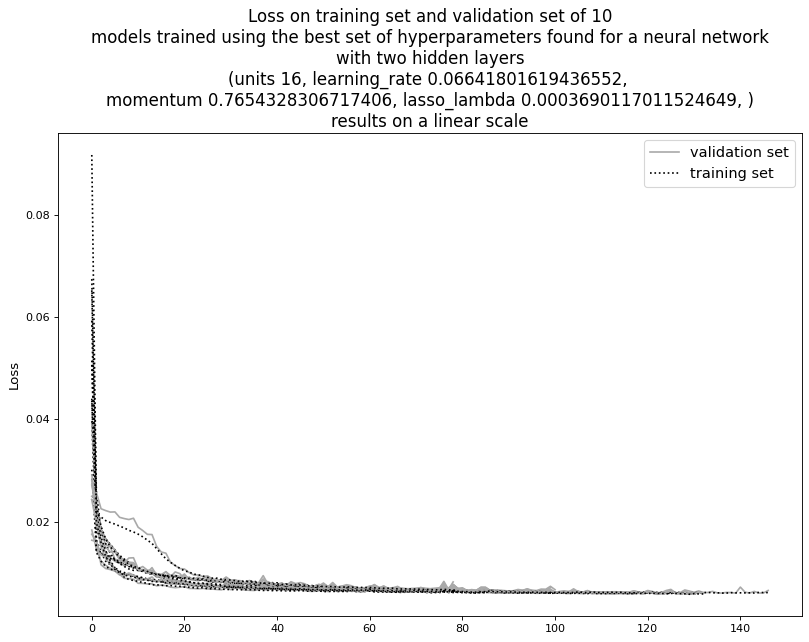

In [41]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

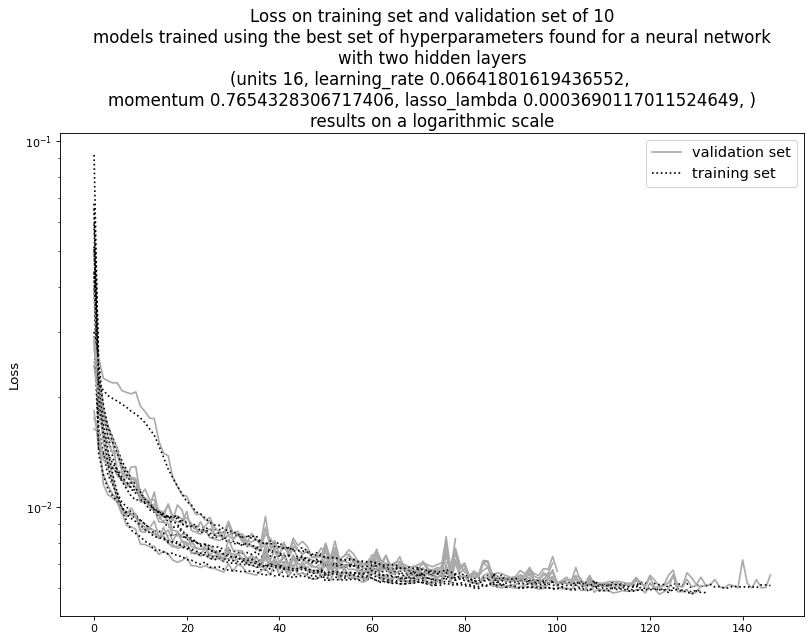

In [42]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

The neural networks with only one hidden layer have better results with respect to the others with two hidden layers. Therefore we decided to return a model among the ones obtained using a single hidden layer.  To retrieve a final model among the ones obtained using a random search, we chose the average model (among those having a single hidden layer) in terms of mean absolute error
on the validation set

In [43]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[int(n_trials/2)][1]

avg_model_val_err = hist[index].history['val_euclidean_distance']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "The validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model = models[index]
avg_model.save("results/ml_cup/nn_RandomSearch/avg_model_single_layer/")

The validation error on the final model for NN with random search is 0.08592294156551361

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_single_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [44]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

print(len(x_mlcup_tr))

predicted_target_tr = avg_model.predict(x_mlcup_tr)

1492
47/47 [==============================] - 0s 801us/step


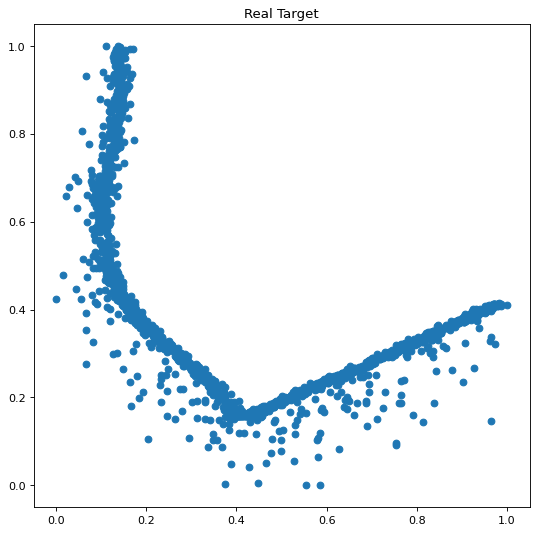

In [45]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

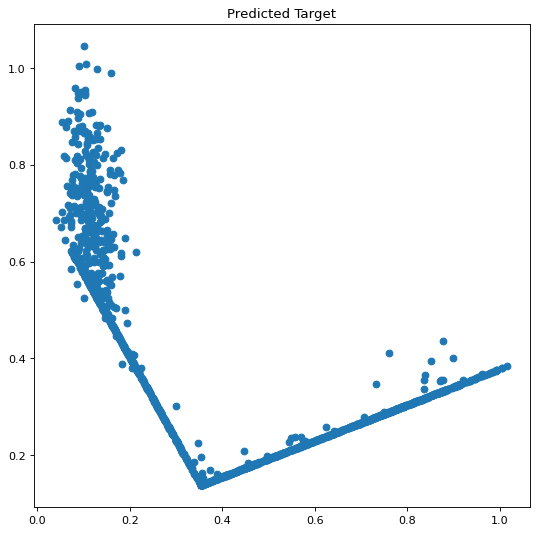

In [46]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1])
plt.title("Predicted Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()

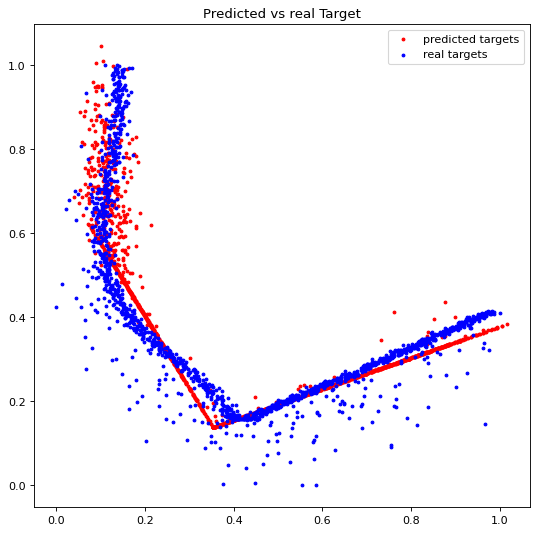

In [54]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_vs_real_target.png")
plt.show()
